# Обзор базовых подходов к решению задачи Uplift Моделирования

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

## Содержание

* [Введение](#Введение)
* [1. Подходы с одной моделью](#1.-Подходы-с-одной-моделью)
    * [1.1 Одна модель](#1.1-Одна-модель-с-признаком-коммуникации)
    * [1.2 Трансформация классов](#1.2-Трансформация-классов)
* [2. Подходы с двумя моделями](#2.-Подходы-с-двумя-моделями)
    * [2.1 Две независимые модели](#2.1-Две-независимые-модели)
    * [2.2 Две зависимые модели](#2.3-Две-зависимые-модели)
* [Заключение](#Заключение)


https://www.uplift-modeling.com/en/latest/install.html

In [2]:
# import sys
# !{sys.executable} -m pip install scikit-uplift==0.5.1 catboost pandas==1.3.5

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from sklift.datasets import fetch_x5
from sklift.metrics import uplift_at_k
from catboost import CatBoostClassifier
import pandas as pd
import numpy as np

In [4]:
random_state = 47
k = 0.1

In [5]:
df_clients = pd.read_csv('fetch_x5_clients.csv')
df_train = pd.read_csv('fetch_x5_train.csv')

# df_clients = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/OTUS/fetch_x5_clients.csv')
# df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/OTUS/fetch_x5_train.csv')

# df_clients содержит данные для обучения и теста, мы оставим только для обучения
# это необходимо, потому что будем замерять качество, а на тестовом семпле таргет  не дан
df_clients = df_clients[df_clients['client_id'].isin(df_train['client_id'])]
print(df_clients.shape, df_train.shape)

(200039, 5) (200039, 3)


In [6]:
df_clients.head(2)

,client_id,first_issue_date,first_redeem_date,age,gender
0,000012768d,2017-08-05 15:40:48,2018-01-04 19:30:07,45,U
1,000036f903,2017-04-10 13:54:23,2017-04-23 12:37:56,72,F


In [7]:
df_train.head(2)

,client_id,treatment_flg,target
0,000012768d,0,1
1,000036f903,1,1


In [8]:
print(f"Dataset features shape: {df_clients.shape}")
print(f"Dataset train shape: {df_train.shape}")
print(f"Dataset target mean: {df_train.target.mean()}")
print(f"Dataset treatment mean: {df_train.treatment_flg.mean()}")

Dataset features shape: (200039, 5)
Dataset train shape: (200039, 3)
Dataset target mean: 0.6198891216212838
Dataset treatment mean: 0.4998075375301816


In [9]:
df_clients = df_clients.set_index('client_id')
df_train = df_train.set_index('client_id')

In [10]:
cat_features = ['gender']

df_clients[cat_features] = df_clients[cat_features].astype('category')

In [11]:
# Извлечение признаков
df_features = df_clients.copy()
df_features['first_issue_time'] = (pd.to_datetime(df_features['first_issue_date'])- pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')
df_features['first_redeem_time'] = (pd.to_datetime(df_features['first_redeem_date']) - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')
df_features['issue_redeem_delay'] = df_features['first_redeem_time'] - df_features['first_issue_time']
df_features = df_features.drop(['first_issue_date', 'first_redeem_date'], axis=1)

df_features.head(2)

,age,gender,first_issue_time,first_redeem_time,issue_redeem_delay
client_id,,,,,
000012768d,45,U,1501947648,1.515094e+09,13146559.0
000036f903,72,F,1491832463,1.492951e+09,1118613.0


In [12]:
# отделяем 30% - пятую часть всего - на тестовую выборку
train, test = train_test_split(df_features, test_size=0.3, random_state=random_state)

indices_train = train.index.tolist()
indices_test = test.index.tolist()

X_train = df_features.loc[indices_train, :]
y_train = df_train.loc[indices_train, 'target']
treat_train = df_train.loc[indices_train, 'treatment_flg']

X_test = df_features.loc[indices_test, :]
y_test = df_train.loc[indices_test, 'target']
treat_test =  df_train.loc[indices_test, 'treatment_flg']

targets = [y_train, y_test]
treatmnets = [treat_train, treat_test]
names = ['train:',  'test:']

print('Баланс таргета на разбиениях:\n')
i = 0
for target in targets:
    pc = target.mean()
    print(names[i], pc)
    i += 1

print('\nБаланс воздействия на разбиениях:\n')
i = 0
for treatmnet in treatmnets:
    pc = treatmnet.mean()
    print(names[i], pc)
    i += 1

Баланс таргета на разбиениях:

train: 0.6201018375027674
test: 0.6193927881090449

Баланс воздействия на разбиениях:

train: 0.49973933598520287
test: 0.4999666733320003


In [13]:
X_test.shape

(60012, 5)

In [14]:
models_results = {
    'approach': [],
    f'train_uplift@{k*100}%': [],
    f'test_uplift@{k*100}%': []
}

# 1. Подходы с одной моделью


## 1.1 Трансформация классов

In [15]:
from sklift.models import ClassTransformation

In [16]:
ct = ClassTransformation(
    CatBoostClassifier(iterations=100, max_depth=4, random_state=42)
    )

ct = ct.fit(X_train, y_train, treat_train,
            estimator_fit_params={
                'cat_features': cat_features,
                'early_stopping_rounds': 10,
                'verbose': False #10
            }
)

uplift_ct_train = ct.predict(X_train)
uplift_ct = ct.predict(X_test)
print(uplift_ct[:5])

[0.04871414 0.00261515 0.02251077 0.02459695 0.12213459]


In [17]:
ct_score_train = uplift_at_k(y_true=y_train, uplift=uplift_ct_train, treatment=treat_train, 
                             strategy='by_group', k=k)
ct_score = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=k)

models_results['approach'].append('ClassTransformation')
models_results[f'train_uplift@{k*100}%'].append(ct_score_train)
models_results[f'test_uplift@{k*100}%'].append(ct_score)

pd.DataFrame(models_results)

,approach,train_uplift@10.0%,test_uplift@10.0%
0,ClassTransformation,0.200909,0.096333


## 1.2 Одна модель с признаком коммуникации

Самое простое и интуитивное решение: модель обучается одновременно на двух группах, при этом бинарный флаг коммуникации выступает в качестве дополнительного признака. Каждый объект из тестовой выборки скорим дважды: с флагом коммуникации равным 1 и равным 0. Вычитая вероятности по каждому наблюдению, получим искомы uplift.

In [18]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from catboost import CatBoostClassifier

In [19]:
sm = SoloModel(
    CatBoostClassifier(iterations=100, max_depth=4, random_state=42)
    )

# Обучаем модель
sm = sm.fit(X_train, y_train, treat_train,
            estimator_fit_params={
                'cat_features': cat_features,
                'early_stopping_rounds': 10,
                'verbose': False #10
            }
)

uplift_sm_train = sm.predict(X_train)
uplift_sm = sm.predict(X_test)
print(uplift_sm[:5])

[0.05174872 0.02409574 0.01861351 0.02217926 0.0247638 ]


In [20]:
sm_score_train = uplift_at_k(y_true=y_train, uplift=uplift_sm_train, treatment=treat_train, strategy='by_group', k=k)
sm_score = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=k)

models_results['approach'].append('SoloModel')
models_results[f'train_uplift@{k*100}%'].append(sm_score_train)
models_results[f'test_uplift@{k*100}%'].append(sm_score)

pd.DataFrame(models_results)

,approach,train_uplift@10.0%,test_uplift@10.0%
0,ClassTransformation,0.200909,0.096333
1,SoloModel,0.053046,0.053667


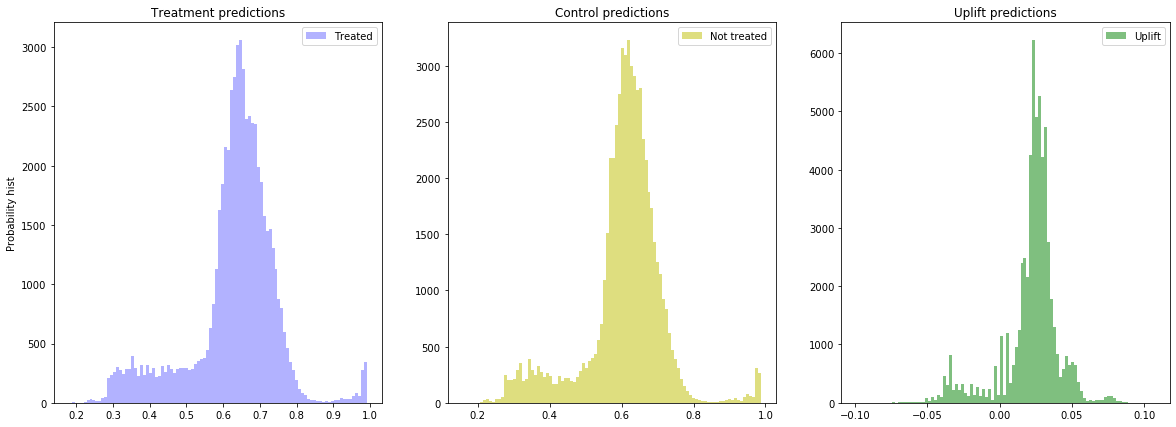

In [21]:
# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

## 2. Подходы с двумя моделями

### 2.1 Две независимые модели

In [22]:
from sklift.models import TwoModels

In [23]:
tm = TwoModels(
    estimator_trmnt = CatBoostClassifier(iterations=100, max_depth=4, random_state=42),
    estimator_ctrl = CatBoostClassifier(iterations=100, max_depth=4, random_state=42),
    method='vanilla'
)

tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={
                'cat_features': cat_features,
                'early_stopping_rounds': 10,
                'verbose': False #10
            },
    estimator_ctrl_fit_params={
                'cat_features': cat_features,
                'early_stopping_rounds': 10,
                'verbose': False #10
            }
)

uplift_tm_train = tm.predict(X_train)
uplift_tm = tm.predict(X_test)
print(uplift_tm[:5])

[ 0.07158929  0.03112211 -0.02752348  0.04444134  0.13468894]


In [24]:
tm_score_train = uplift_at_k(y_true=y_train, uplift=uplift_tm_train, treatment=treat_train, strategy='by_group', k=k)
tm_score = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=k)

models_results['approach'].append('TwoModels')
models_results[f'train_uplift@{k*100}%'].append(tm_score_train)
models_results[f'test_uplift@{k*100}%'].append(tm_score)

pd.DataFrame(models_results)

,approach,train_uplift@10.0%,test_uplift@10.0%
0,ClassTransformation,0.200909,0.096333
1,SoloModel,0.053046,0.053667
2,TwoModels,0.186148,0.065667


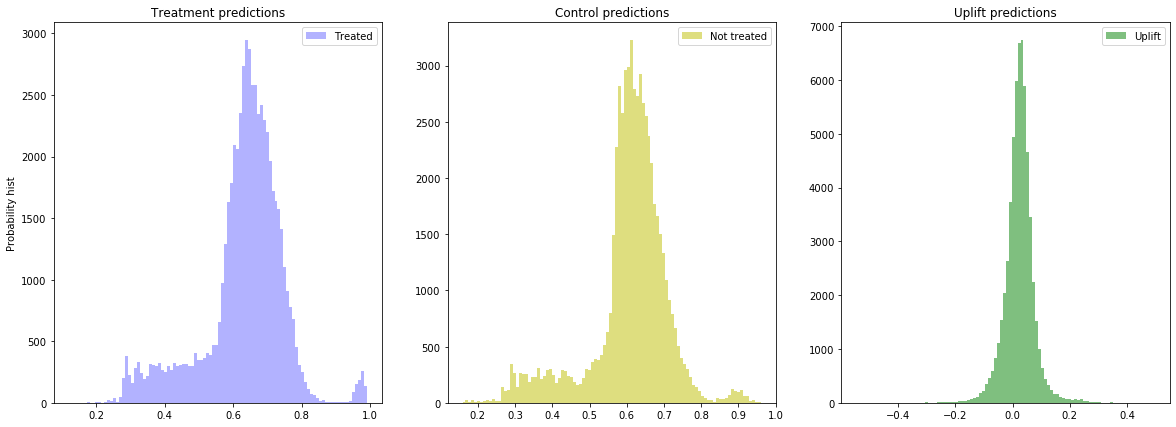

In [25]:
# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
tm_trmnt_preds = tm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
tm_ctrl_preds = tm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=tm_trmnt_preds, ctrl_preds=tm_ctrl_preds);

### 2.2 Две зависимые модели

In [26]:
tm_ctrl = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=100, max_depth=4, random_state=42),
    estimator_ctrl=CatBoostClassifier(iterations=100, max_depth=4, random_state=42),
    method='ddr_control'
)

tm_ctrl = tm_ctrl.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={
                'cat_features': cat_features,
                'early_stopping_rounds': 10,
                'verbose': False #10
            },
    estimator_ctrl_fit_params={
                'cat_features': cat_features,
                'early_stopping_rounds': 10,
                'verbose': False #10
            }
)

uplift_tm_ctrl_train = tm_ctrl.predict(X_train)
uplift_tm_ctrl = tm_ctrl.predict(X_test)
print(uplift_tm_ctrl[:5])

[ 0.06003539  0.04004962 -0.00483327  0.02083803  0.1312127 ]


In [27]:
tm_ctrl_score_train = uplift_at_k(y_true=y_train, uplift=uplift_tm_ctrl_train, treatment=treat_train, strategy='by_group', k=k)
tm_ctrl_score = uplift_at_k(y_true=y_test, uplift=uplift_tm_ctrl, treatment=treat_test, strategy='by_group', k=k)

models_results['approach'].append('TwoModels_ddr_control')
models_results[f'train_uplift@{k*100}%'].append(tm_ctrl_score_train)
models_results[f'test_uplift@{k*100}%'].append(tm_ctrl_score)


pd.DataFrame(models_results)

,approach,train_uplift@10.0%,test_uplift@10.0%
0,ClassTransformation,0.200909,0.096333
1,SoloModel,0.053046,0.053667
2,TwoModels,0.186148,0.065667
3,TwoModels_ddr_control,0.194751,0.085000


In [28]:
# plot_uplift_preds(trmnt_preds=tm_ctrl.trmnt_preds_, ctrl_preds=tm_ctrl.ctrl_preds_);

Аналогичным образом можно сначала обучить классификатор $P^T$, а затем использовать его предсказания в качестве признака для классификатора $P^C$.

In [29]:
tm_trmnt = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=100, max_depth=4, random_state=42),
    estimator_ctrl=CatBoostClassifier(iterations=100, max_depth=4, random_state=42),
    method='ddr_treatment'
)

tm_trmnt = tm_trmnt.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={
                'cat_features': cat_features,
                'early_stopping_rounds': 10,
                'verbose': False #10
            },
    estimator_ctrl_fit_params={
                'cat_features': cat_features,
                'early_stopping_rounds': 10,
                'verbose': False #10
            }
)

uplift_tm_trmnt_train = tm_trmnt.predict(X_train)
uplift_tm_trmnt = tm_trmnt.predict(X_test)
print(uplift_tm_trmnt[:5])

[0.06856123 0.00375784 0.01840938 0.01825481 0.11574537]


In [30]:
tm_trmnt_score_train = uplift_at_k(y_true=y_train, uplift=uplift_tm_trmnt_train, treatment=treat_train, strategy='by_group', k=k)
tm_trmnt_score = uplift_at_k(y_true=y_test, uplift=uplift_tm_trmnt, treatment=treat_test, strategy='by_group', k=k)

models_results['approach'].append('TwoModels_ddr_treatment')
models_results[f'train_uplift@{k*100}%'].append(tm_trmnt_score_train)
models_results[f'test_uplift@{k*100}%'].append(tm_trmnt_score)

pd.DataFrame(models_results)

,approach,train_uplift@10.0%,test_uplift@10.0%
0,ClassTransformation,0.200909,0.096333
1,SoloModel,0.053046,0.053667
2,TwoModels,0.186148,0.065667
3,TwoModels_ddr_control,0.194751,0.085000
4,TwoModels_ddr_treatment,0.153695,0.046333


In [31]:
# plot_uplift_preds(trmnt_preds=tm_trmnt.trmnt_preds_, ctrl_preds=tm_trmnt.ctrl_preds_);

## Метрики


In [32]:
pd.DataFrame(data=models_results).sort_values(f'test_uplift@{k*100}%', ascending=False)

,approach,train_uplift@10.0%,test_uplift@10.0%
0,ClassTransformation,0.200909,0.096333
3,TwoModels_ddr_control,0.194751,0.085000
2,TwoModels,0.186148,0.065667
1,SoloModel,0.053046,0.053667
4,TwoModels_ddr_treatment,0.153695,0.046333


In [33]:
# Проверка структуры данных. Необходимо, чтобы запустился расчет метрик на особых версиях библиотек
print(f'y_test структура: {y_test.shape}, тип: {y_test.dtype}')
print(f'uplift_ct структура: {uplift_ct.shape}, тип: {uplift_ct.dtype}')
print(f'treat_test структура: {treat_test.shape}, тип: {treat_test.dtype}')

# Если обнаружены вложенные структуры, преобразовать их в одномерные массивы
if y_test.ndim > 1:
    y_test = y_test.flatten()

if uplift_ct.ndim > 1:
    uplift_ct = uplift_ct.flatten()

if treat_test.ndim > 1:
    treat_test = treat_test.flatten()

y_test структура: (60012,), тип: int64
uplift_ct структура: (60012,), тип: float64
treat_test структура: (60012,), тип: int64


In [34]:
from sklift.metrics import uplift_by_percentile

uplift_by_percentile(y_test, uplift_ct, treat_test,
                     strategy='overall',
                     total=True, std=True, bins=10)

/Users/pozdneeva/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift,std_treatment,std_control,std_uplift
percentile,,,,,,,,
0-10,3346,2656,0.733413,0.640437,0.092976,0.007644,0.009311,0.012047
10-20,3098,2904,0.665913,0.634642,0.031272,0.008474,0.008936,0.012315
20-30,2978,3023,0.669577,0.604697,0.064880,0.008619,0.008892,0.012384
30-40,2971,3030,0.648603,0.611551,0.037052,0.008759,0.008854,0.012455
40-50,2932,3069,0.662005,0.620723,0.041282,0.008736,0.008758,0.012370
50-60,2967,3034,0.626559,0.607119,0.019439,0.008880,0.008867,0.012549
60-70,2958,3043,0.614943,0.585606,0.029336,0.008947,0.008930,0.012641
70-80,2978,3023,0.609805,0.588488,0.021317,0.008939,0.008950,0.012649
80-90,2994,3007,0.575818,0.572664,0.003155,0.009032,0.009021,0.012766


In [35]:
from sklift.metrics import weighted_average_uplift

uplift_full_data_ct = weighted_average_uplift(y_test, uplift_ct, treat_test, bins=10)
uplift_full_data_sm = weighted_average_uplift(y_test, uplift_sm, treat_test, bins=10)
print(f"average uplift on test data CT: {uplift_full_data_ct:.4f}")
print(f"average uplift on test data SM: {uplift_full_data_sm:.4f}")

average uplift on test data CT: 0.0338
average uplift on test data SM: 0.0343


/Users/pozdneeva/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


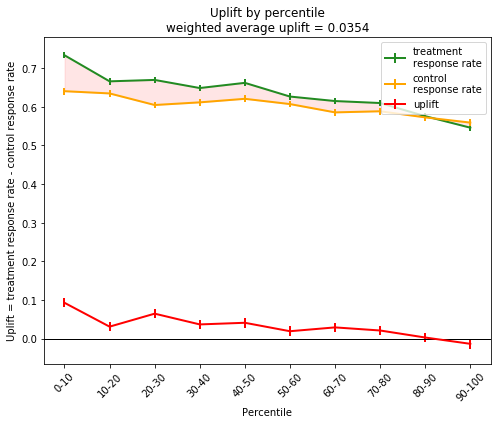

In [36]:
from sklift.viz import plot_uplift_by_percentile

# line plot
plot_uplift_by_percentile(y_test, uplift_ct, treat_test,
                          strategy='overall', kind='line');

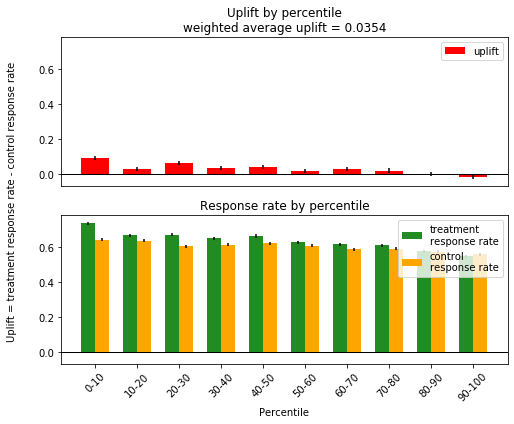

In [37]:
# bar plot
plot_uplift_by_percentile(y_test, uplift_ct, treat_test, strategy='overall', kind='bar');

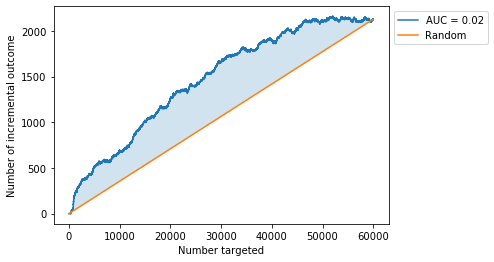

In [38]:
from sklift.viz import plot_uplift_curve

# with ideal curve
# perfect=True
plot_uplift_curve(y_test, uplift_ct, treat_test, perfect=False);

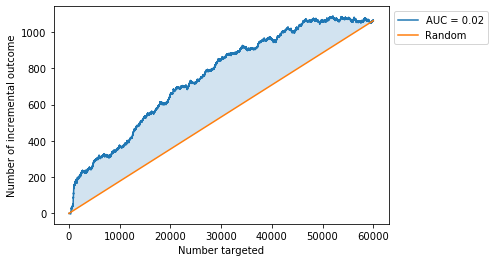

In [39]:
from sklift.viz import plot_qini_curve

# with ideal Qini curve (red line)
# perfect=True
plot_qini_curve(y_test, uplift_ct, treat_test, perfect=False);